In [1]:
import pandas as pd
import numpy as np
import os
import pickle
from collections import Counter

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize

In [5]:
from scipy import stats
from scipy.stats import norm, gamma, linregress, skew
from sklearn.cluster import KMeans, SpectralClustering, AgglomerativeClustering 
from sklearn.preprocessing import StandardScaler, RobustScaler, Normalizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, confusion_matrix, silhouette_score, silhouette_samples

In [6]:
def dump_pickle(file, filename):
    outfile = open(filename, 'wb')
    pickle.dump(file, outfile)
    outfile.close()

def load_pickle(filename):
    infile = open(filename, 'rb')
    file = pickle.load(infile)
    infile.close()
    return file

In [7]:
sns.set()

## Data Prep

### Read Synergy Data

In [8]:
s_df = pd.read_csv('euroleague_offense.csv')
s_df = s_df[s_df['Season'] != 2016]
s_df['Player'] = s_df['Player'].apply(lambda x: ' '.join(x.split(' ')[1:]))
s_df.shape

(1363, 74)

Include labels regarding half court offense only

In [9]:
s_df['Overall_Poss'] = s_df['Overall_Poss'] - s_df['Miscellaneous_Poss']

In [10]:
poss_weights_cols = ['Spot Up_Poss%', 'P&R Ball Handler_Poss%', 
                     'Hand Off_Poss%', 'Off Screen_Poss%',
                     'Cut_Poss%', 'Offensive Rebounds (put backs)_Poss%',
                     'P&R Roll Man_Poss%', 'Isolation_Poss%', 
                     'Post-Up_Poss%', 'Transition_Poss%'] 

In [11]:
for col in poss_weights_cols:
    s_df[col] = s_df[col.replace('%', '')] / s_df['Overall_Poss']
    s_df[col] = s_df[col].fillna(0)

Filter in players with 200 shot possessions

In [12]:
s_df = s_df[s_df['Overall_Poss'] >= 200]
s_df.shape

(445, 74)

### Merge Synergy Data & BBR Data

In [13]:
df = s_df.copy().reset_index().drop('index', axis=1)
df.shape

(445, 74)

## Functions

In [14]:
poss_ppp_cols = ['Spot Up_PPP', 'P&R Ball Handler_PPP', 
                 'Cut_PPP', 'Hand Off_PPP', 'Offensive Rebounds (put backs)_PPP',
                 'P&R Roll Man_PPP', 'Isolation_PPP', 'Off Screen_PPP',
                 'Post-Up_PPP', 'Transition_PPP']

In [15]:
def find_optimal_k(x):
    avg_ss_list = []
    k_list = list(range(2, 11))
    for k in k_list:
        sc = SpectralClustering(n_clusters=k, 
                                eigen_solver="arpack",
                                affinity="nearest_neighbors")
        cluster_labels = sc.fit(x).labels_
        avg_silhouette_score = silhouette_score(x, cluster_labels)
        avg_ss_list.append(avg_silhouette_score)
        
    top_ss = np.max(avg_ss_list)
    for i in range(len(k_list)):
        if avg_ss_list[i] == top_ss:
            return k_list[i]

In [16]:
def plot_silhouette_score(x):
    avg_ss_list = []
    k_list = list(range(2, 16))
    for k in k_list:
        sc = SpectralClustering(n_clusters=k, affinity='nearest_neighbors', random_state=42)
        cluster_labels = sc.fit(x).labels_
        avg_silhouette_score = silhouette_score(x, cluster_labels)
        avg_ss_list.append(avg_silhouette_score)

    # Plot
    plt.plot(k_list, avg_ss_list, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Average Silhouette Score')
    plt.title('The Silhouette Score Method showing the optimal k')

In [17]:
def plot_pca_explained_var(x):
    ev_list = []
    c_list = list(range(2, 8))
    for c in c_list:
        pca = PCA(n_components=c)
        ev_list.append(np.sum(pca.fit(x).explained_variance_ratio_))
    
    # Plot
    plt.plot(c_list, ev_list)
    plt.hlines(0.95, 2, 7, color='red', linestyle='--')
    plt.xlabel('c')
    plt.ylabel('Explained Variance Ratio')

In [18]:
def get_playtype_dist(df, poss_ppp_cols=poss_ppp_cols):
    playtype_dfs = []
    for col in poss_ppp_cols:
        playtype = col.replace('_PPP', '')
        playtype_df = pd.DataFrame()
        playtype_df['PPP'] = df[col]
        playtype_df['Poss%'] = df[f'{playtype}_Poss%'] * 100
        playtype_df['playtype'] = playtype
        playtype_dfs.append(playtype_df)   
    return pd.concat(playtype_dfs)

In [19]:
def show_cluster_res(df, cluster_col, poss_weights_cols=poss_weights_cols):
    cluster_res = df.groupby(cluster_col)[poss_weights_cols]\
                    .mean()
    cluster_cnt = Counter(df[cluster_col])
    for col in cluster_res.columns:
        if '%' in col:
            cluster_res[col] = cluster_res[col].apply(lambda x: f'{x:.2%}')
    cluster_res = cluster_res.reset_index()
    cluster_res['#'] = cluster_res[cluster_col].map(cluster_cnt)
    return cluster_res.T

In [20]:
def plot_cluster_res_2d(df, cluster_col, col1, col2, cluster_dict):
    clusters = list(set(df[cluster_col]))
    for cluster in clusters:
        cluster_cond = df[cluster_col] == cluster
        x = df[cluster_cond][col1].values * 100
        y = df[cluster_cond][col2].values * 100
        plt.scatter(x, y, 
                    label=f'Cluster {cluster}: {cluster_dict[cluster]}', 
                    alpha=0.3)
        plt.xlabel(col1)
        plt.ylabel(col2)
        plt.legend()

In [21]:
def check_cluster_robustness(x, k, n_iters):
    cluster_res = []
    for i in range(n_iters):
        sc = SpectralClustering(n_clusters=k, affinity='nearest_neighbors')
        pred = sc.fit(x).labels_
        res = sorted([list(pred).count(cluster) for cluster in list(range(k))])
        cluster_res.append('-'.join([str(n) for n in res]))
    return Counter(cluster_res)

In [22]:
def display_cluster_players(df, cluster_col, cluster_label):
    cols = ['Player', 'Season', 'Team', 'Overall_PPP']
    best_10 = df[df[cluster_col] == cluster_label].sort_values('Overall_PPP', ascending=False)\
                                                  .head(10)[cols]\
                                                  .rename(columns={'Player': 'Best 10 Players'})\
                                                  .reset_index().drop('index', axis=1)
    worst_10 = df[df[cluster_col] == cluster_label].sort_values('Overall_PPP')\
                                                   .head(10)[cols]\
                                                   .rename(columns={'Player': 'Worst 10 Players'})\
                                                   .reset_index().drop('index', axis=1)
    return pd.concat([best_10, worst_10], axis=1)

## Clustering

Show correlations among playtype possession%

<AxesSubplot:>

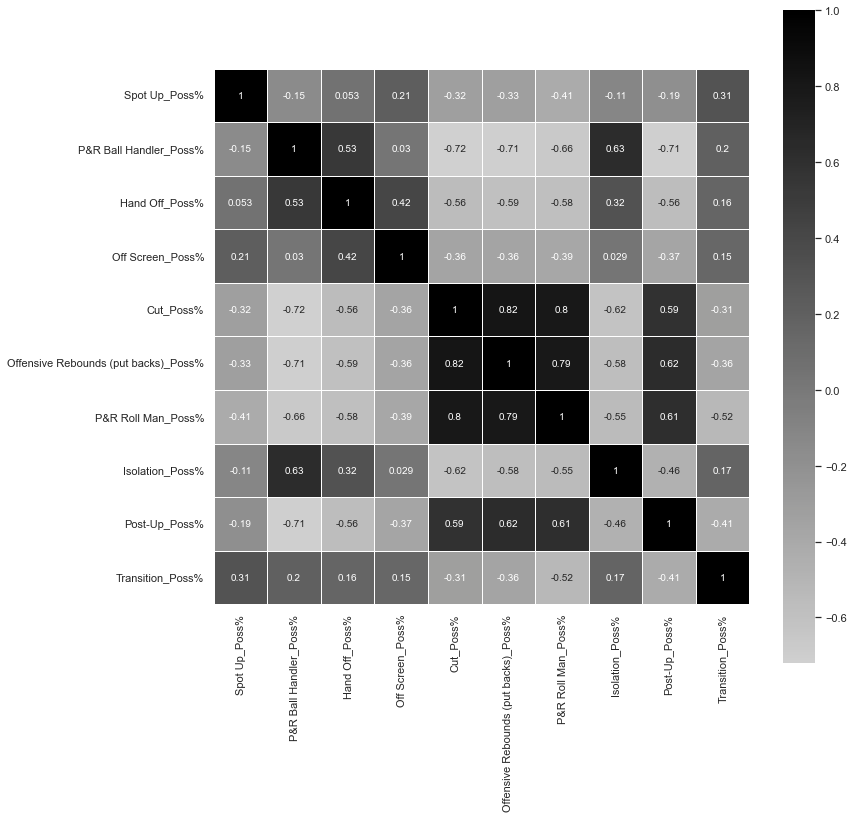

In [23]:
figsize(12, 8)
corr = df[poss_weights_cols].corr()
f, ax = plt.subplots(figsize=(12, 12))
cmap = sns.light_palette('black', as_cmap=True)
sns.heatmap(corr, 
            cmap=cmap, vmax=None, center=0,square=True, annot=True, linewidths=.5)

Show distributions of possession weights and effeiciency of each playtype

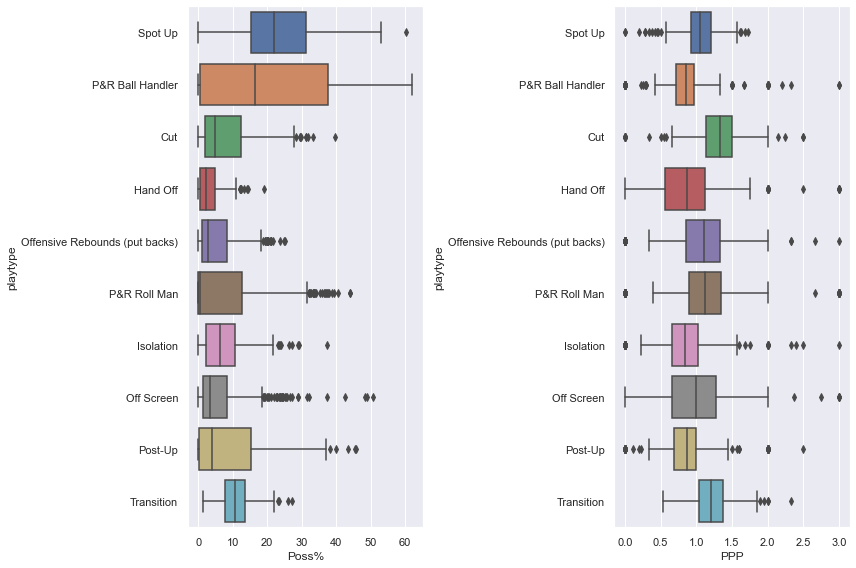

In [24]:
figsize(12, 8)
data = get_playtype_dist(df)
plt.subplot(1, 2, 1)
sns.boxplot(x="Poss%", y="playtype", data=data)
plt.subplot(1, 2, 2)
sns.boxplot(x="PPP", y="playtype", data=data)
plt.tight_layout()

Summary of distribution in playtype weights:
- Outliers exist 
    - Most of them are the result of skewed data
    - A few of them are creditted to players' own unique tendencies (ex. James Harden's iso game)
- There are some common playtypes
    - Spot Up
    - Transition
- Most are skewed
    - Big man
        - Cut
        - Offensive Rebounds
        - P&R Roll Man
        - Post-Up
    - Perimeter players
        - P&R Ball Handler
        - Hand Off
        - Off Screen
    - Star Privilege
        - Post-Up
        - Isolation
    
        

### Clustering

In [25]:
X = df[poss_weights_cols].copy()

Determine how many components reduce down to via PCA

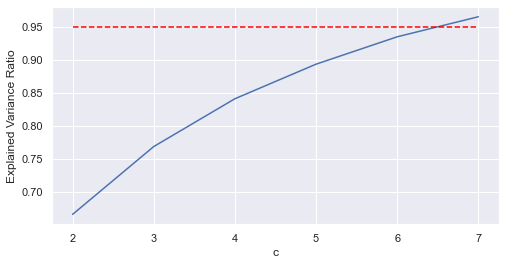

In [26]:
figsize(8, 4)
pre_pca_pipe = make_pipeline(RobustScaler(), StandardScaler())
plot_pca_explained_var(pre_pca_pipe.fit_transform(X))

Choose 6

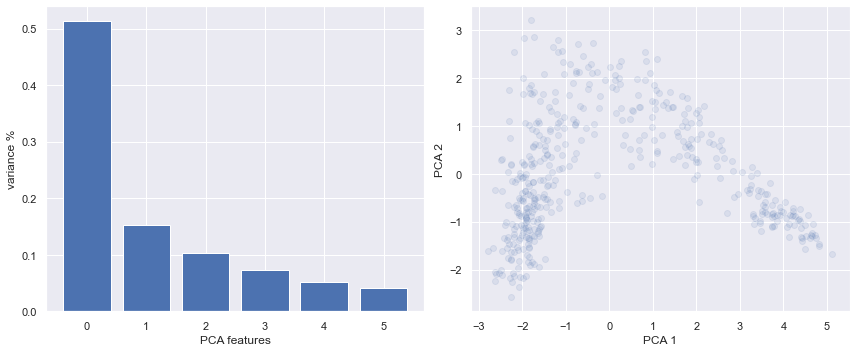

In [27]:
pre_pca_pipe = make_pipeline(RobustScaler(), StandardScaler())
pca = PCA(n_components=6)
pca.fit(pre_pca_pipe.fit_transform(X))
pca_components = pca.transform(pre_pca_pipe.fit_transform(X))

figsize(12, 5)
plt.subplot(1, 2, 1)
plt.bar(range(pca.n_components_), pca.explained_variance_ratio_)
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(range(pca.n_components_))

plt.subplot(1, 2, 2)
plt.scatter(pca_components[:, 0], pca_components[:, 1], alpha=.1)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')

plt.tight_layout()

In [28]:
pre_cluster_scaler = StandardScaler()
X_transformed = pre_cluster_scaler.fit_transform(pca_components)

Determine # of clusters using silhouette score method

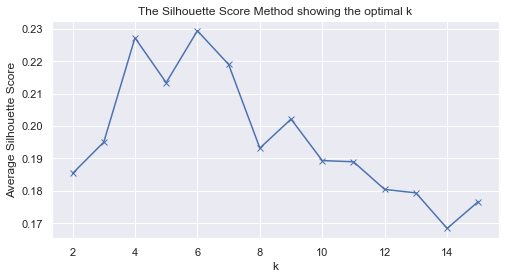

In [29]:
figsize(8, 4)
plot_silhouette_score(X_transformed)

Try 500 times to see if the clustering result stays robust. It turns out the algorithm delivers the same result 

In [30]:
# # Check stability
# check_cluster_robustness(X_transformed, 7, 500)

### Results

In [30]:
# Choose k = 6
sc = SpectralClustering(n_clusters=6, affinity='nearest_neighbors', random_state=42)
sc.fit(X_transformed)
df['player_cluster'] = sc.labels_
df['silhouette_coefficient'] = silhouette_samples(X_transformed, df['player_cluster'])
df.groupby('player_cluster').count()['Player']

player_cluster
0     58
1     42
2     66
3     88
4    107
5     84
Name: Player, dtype: int64

#### OBPM & Usage by Cluster

In [31]:
show_cluster_res(df, 'player_cluster')

,0,1,2,3,4,5
player_cluster,0,1,2,3,4,5
Spot Up_Poss%,21.64%,25.72%,9.01%,21.61%,36.13%,18.01%
P&R Ball Handler_Poss%,2.02%,19.34%,0.26%,42.12%,9.63%,40.12%
Hand Off_Poss%,0.81%,6.03%,0.10%,6.37%,1.90%,3.25%
Off Screen_Poss%,2.52%,24.89%,0.82%,4.46%,6.42%,4.95%
Cut_Poss%,11.21%,3.04%,21.99%,2.51%,8.90%,1.93%
Offensive Rebounds (put backs)_Poss%,8.37%,1.90%,14.63%,1.17%,5.60%,1.78%
P&R Roll Man_Poss%,12.47%,0.36%,28.93%,0.13%,5.56%,0.35%
Isolation_Poss%,4.55%,7.20%,1.33%,9.14%,4.33%,15.43%
Post-Up_Poss%,28.11%,1.06%,16.43%,1.37%,7.72%,2.03%


- Ballhandler: 3 & 5
- Big: 0 & 2
- Wing: 1 & 4

In [32]:
cluster_dict = {3: 'Ballhandler', 5: 'Ballhandler',
                0: 'Big', 2: 'Big',
                1: 'Wing', 4: 'Wing'}

In [33]:
def color_cluster(val, cluster_dict=cluster_dict):
    if cluster_dict[val] == 'Ballhandler':
        return '#AB3B3A'
    elif cluster_dict[val] == 'Wing':
        return '#2E5C6E'
    elif cluster_dict[val] == 'Big':
        return '#F7D94C'

In [34]:
def color_cluster_pandas(val, cluster_dict=cluster_dict):
    if val in cluster_dict.keys():
        color = color_cluster(val, cluster_dict=cluster_dict)
    else:
        color = 'white'
    return f'background-color: {color}' 

In [35]:
show_cluster_res(df, 'player_cluster')\
.style.applymap(color_cluster_pandas)

,0,1,2,3,4,5
player_cluster,0,1,2,3,4,5
Spot Up_Poss%,21.64%,25.72%,9.01%,21.61%,36.13%,18.01%
P&R Ball Handler_Poss%,2.02%,19.34%,0.26%,42.12%,9.63%,40.12%
Hand Off_Poss%,0.81%,6.03%,0.10%,6.37%,1.90%,3.25%
Off Screen_Poss%,2.52%,24.89%,0.82%,4.46%,6.42%,4.95%
Cut_Poss%,11.21%,3.04%,21.99%,2.51%,8.90%,1.93%
Offensive Rebounds (put backs)_Poss%,8.37%,1.90%,14.63%,1.17%,5.60%,1.78%
P&R Roll Man_Poss%,12.47%,0.36%,28.93%,0.13%,5.56%,0.35%
Isolation_Poss%,4.55%,7.20%,1.33%,9.14%,4.33%,15.43%
Post-Up_Poss%,28.11%,1.06%,16.43%,1.37%,7.72%,2.03%


#### Possession Weights by Cluster

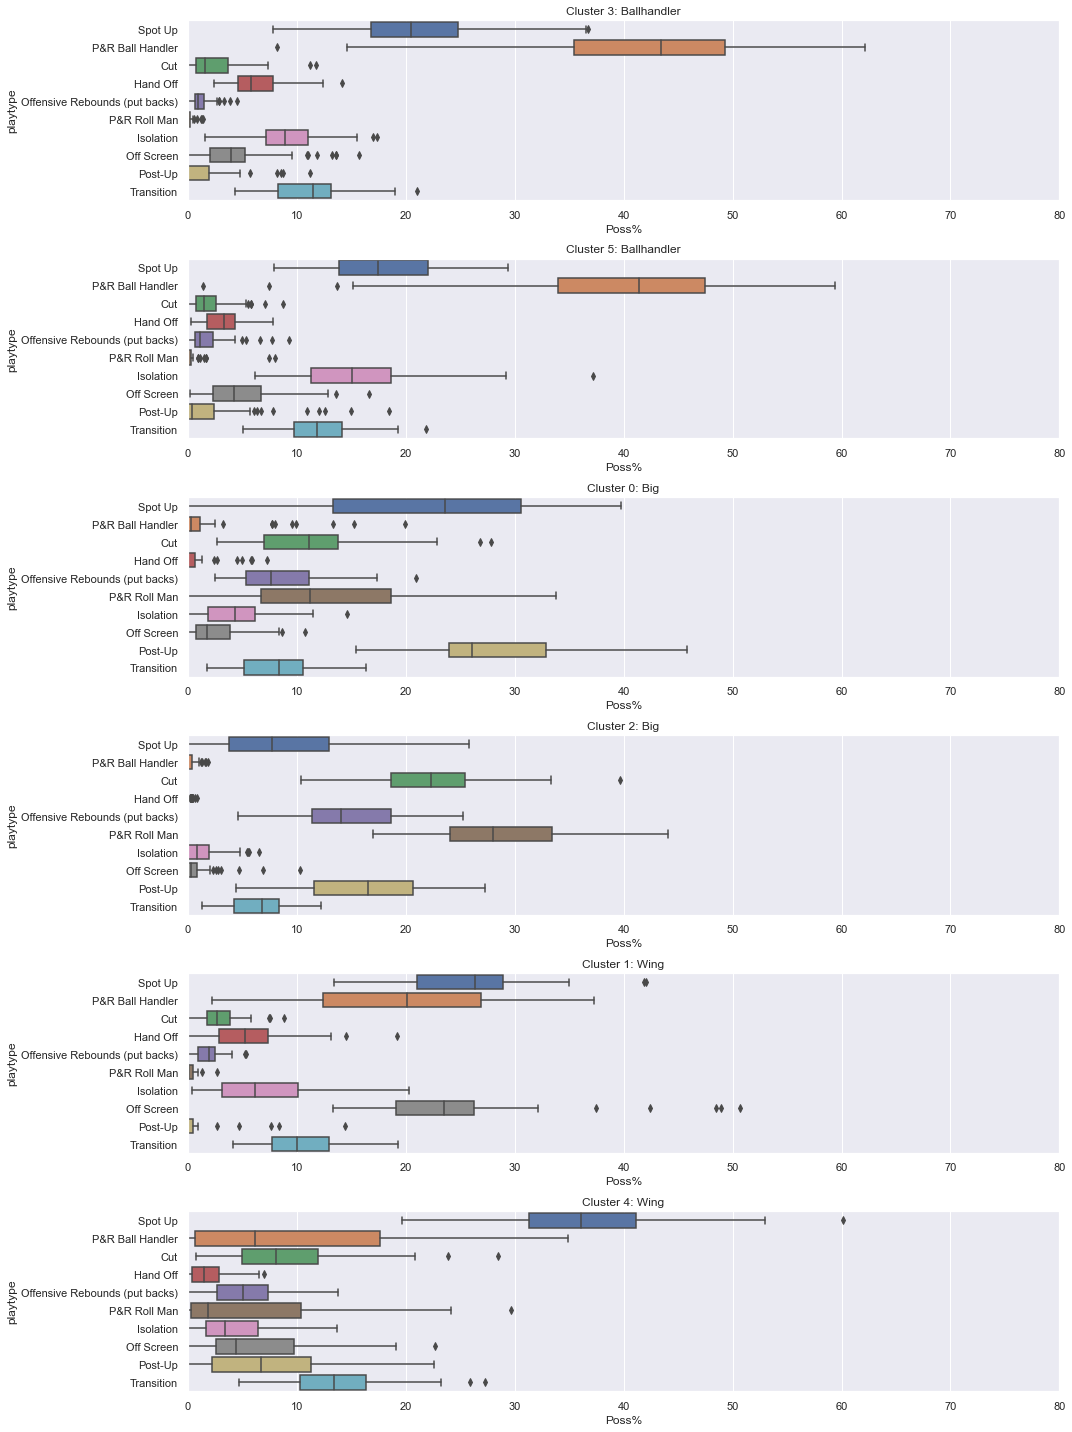

In [36]:
figsize(15, 20)
n_clusters = len(set(df['player_cluster']))
data_dict = {cluster: get_playtype_dist(df[df['player_cluster'] == cluster])
             for cluster in range(n_clusters)}

for idx, cluster in enumerate(list(cluster_dict.keys()), 1):
    data = get_playtype_dist(df[df['player_cluster'] == cluster])
    plt.subplot(n_clusters, 1, idx)
    sns.boxplot(x="Poss%", y="playtype", data=data_dict[cluster])
    plt.title(f'Cluster {cluster}: {cluster_dict[cluster]}')
    plt.xlim(0, 80)

plt.tight_layout()

Summary of distribution in playtype weights:
- Good:
    - Cluster separate playtypes regarding pick & roll nicely
    - Cluster separate iso & post-up nicely
- Bad:
    - Skewed data & Outliers still exist

#### Observations

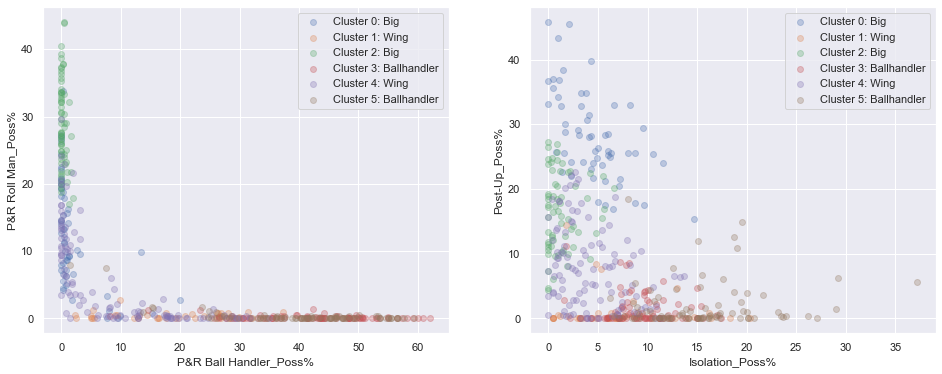

In [37]:
figsize(16, 6)
plt.subplot(1, 2, 1)
plot_cluster_res_2d(df, 
                    cluster_col='player_cluster', 
                    col1='P&R Ball Handler_Poss%', 
                    col2='P&R Roll Man_Poss%',
                    cluster_dict=cluster_dict)
plt.subplot(1, 2, 2)
plot_cluster_res_2d(df, 
                    cluster_col='player_cluster', 
                    col1='Isolation_Poss%', 
                    col2='Post-Up_Poss%',
                    cluster_dict=cluster_dict)

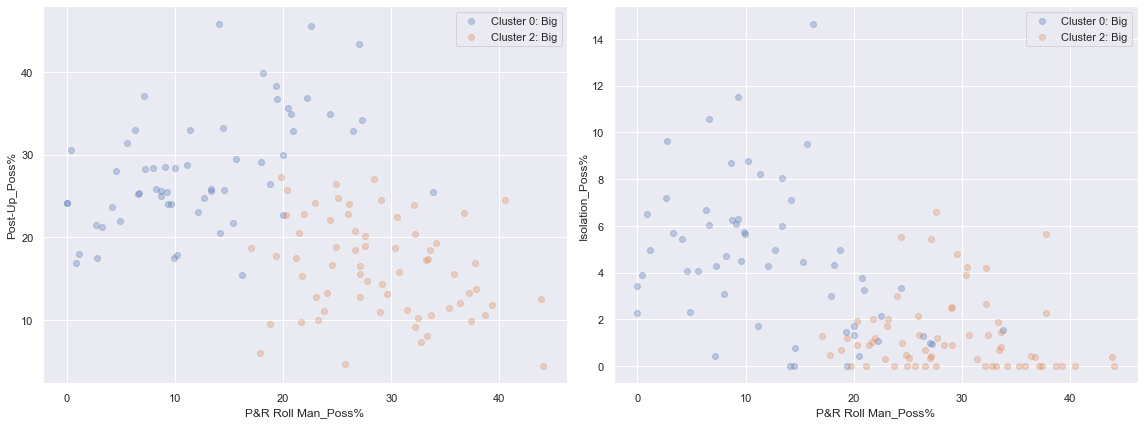

In [38]:
figsize(16, 6)
plt.subplot(1, 2, 1)
plot_cluster_res_2d(df[df['player_cluster'].isin([cluster 
                                                  for cluster in cluster_dict.keys() 
                                                  if cluster_dict[cluster] == 'Big'])], 
                    cluster_col='player_cluster', 
                    col1='P&R Roll Man_Poss%', 
                    col2='Post-Up_Poss%',
                    cluster_dict=cluster_dict)
plt.subplot(1, 2, 2)
plot_cluster_res_2d(df[df['player_cluster'].isin([cluster 
                                                  for cluster in cluster_dict.keys() 
                                                  if cluster_dict[cluster] == 'Big'])], 
                    cluster_col='player_cluster', 
                    col1='P&R Roll Man_Poss%', 
                    col2='Isolation_Poss%',
                    cluster_dict=cluster_dict)
plt.tight_layout()

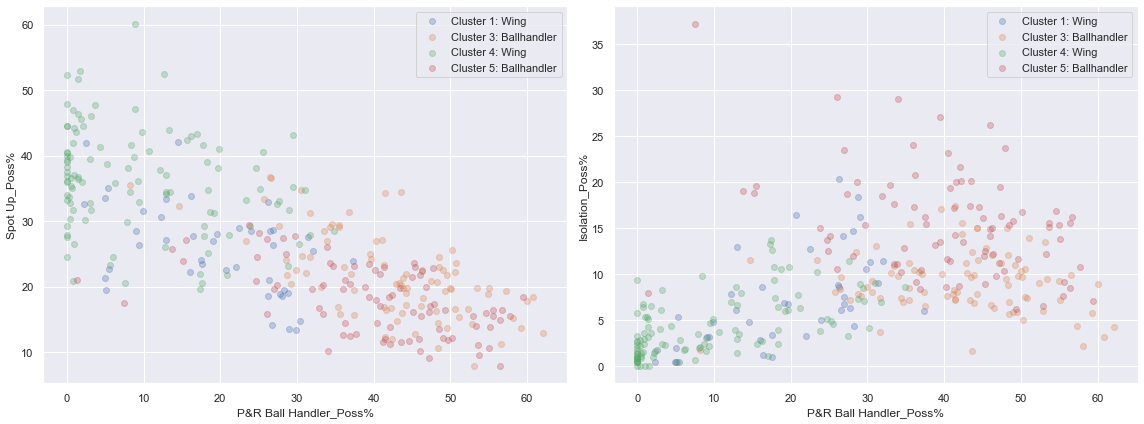

In [39]:
figsize(16, 6)
plt.subplot(1, 2, 1)
plot_cluster_res_2d(df[df['player_cluster'].isin([cluster 
                                                  for cluster in cluster_dict.keys() 
                                                  if cluster_dict[cluster] != 'Big'])], 
                    cluster_col='player_cluster', 
                    col1='P&R Ball Handler_Poss%', 
                    col2='Spot Up_Poss%',
                    cluster_dict=cluster_dict)
plt.subplot(1, 2, 2)
plot_cluster_res_2d(df[df['player_cluster'].isin([cluster 
                                                  for cluster in cluster_dict.keys() 
                                                  if cluster_dict[cluster] != 'Big'])], 
                    cluster_col='player_cluster', 
                    col1='P&R Ball Handler_Poss%', 
                    col2='Isolation_Poss%',
                    cluster_dict=cluster_dict)
plt.tight_layout()

#### Distributions

#### Ballhandler

In [40]:
c = 5
print('# Players:', df.groupby('player_cluster').count()['Player'][c])
display_cluster_players(df, 'player_cluster', c)

# Players: 84


,Best 10 Players,Season,Team,Overall_PPP,Worst 10 Players,Season,Team,Overall_PPP
0,Shane Larkin,2019,Anadolu Efes Istanbul,1.290,Nick Calathes,2018,Panathinaikos OPAP Athens,0.727
1,Cory Higgins,2017,CSKA Moscow,1.144,Nick Calathes,2020,FC Barcelona,0.740
2,Shane Larkin,2018,Anadolu Efes Istanbul,1.140,Pierria Henry,2021,Fenerbahce Beko Istanbul,0.769
3,Jimmer Fredette,2019,Panathinaikos OPAP Athens,1.132,Nick Calathes,2019,Panathinaikos OPAP Athens,0.791
4,Kevin Punter,2020,AX Armani Exchange Milano,1.115,Pierria Henry,2019,TD Systems Baskonia Vitoria-Gasteiz,0.794
5,Corey Walden,2021,FC Bayern München,1.108,Lorenzo Brown,2020,Fenerbahce Beko Istanbul,0.823
6,Nikola Mirotic,2019,FC Barcelona,1.103,Lorenzo Brown,2019,Crvena Zvezda mts,0.826
7,Erick Green,2017,Valencia Basket,1.099,Pierria Henry,2020,TD Systems Baskonia Vitoria-Gasteiz,0.847
8,Sergio Rodriguez,2017,CSKA Moscow,1.084,Vassilis Spanoulis,2017,Olympiacos Pireaus,0.854
9,Krunoslav Simon,2020,Anadolu Efes Istanbul,1.056,Ray McCallum,2017,Unicaja Malaga,0.857


In [41]:
c = 3
print('# Players:', df.groupby('player_cluster').count()['Player'][c])
display_cluster_players(df, 'player_cluster', c)

# Players: 88


,Best 10 Players,Season,Team,Overall_PPP,Worst 10 Players,Season,Team,Overall_PPP
0,Marko Guduric,2018,Fenerbahce Beko Istanbul,1.183,Stefan Markovic,2017,Khimki Moscow Region,0.716
1,Petteri Koponen,2018,FC Bayern München,1.171,Vassilis Spanoulis,2020,Olympiacos Pireaus,0.727
2,Bobby Dixon,2018,Fenerbahce Beko Istanbul,1.165,Jayson Granger,2021,TD Systems Baskonia Vitoria-Gasteiz,0.761
3,Vladimir Lucic,2019,FC Bayern München,1.159,Nemanja Gordic,2018,Buducnost VOLI Podgorica,0.764
4,Cory Higgins,2018,CSKA Moscow,1.143,Vassilis Spanoulis,2018,Olympiacos Pireaus,0.799
5,Nando de Colo,2017,CSKA Moscow,1.138,Quino Colom,2019,Valencia Basket,0.800
6,Shavon Shields,2020,AX Armani Exchange Milano,1.130,Sergio Llull,2021,Real Madrid,0.804
7,Konstantinos Sloukas,2018,Fenerbahce Beko Istanbul,1.112,Vasilije Micic,2017,Zalgiris Kaunas,0.805
8,Nando de Colo,2018,CSKA Moscow,1.104,Andrew Albicy,2019,Zenit Saint Petersburg,0.808
9,Nicolas Laprovittola,2021,FC Barcelona,1.074,Martin Hermannsson,2019,ALBA Berlin,0.810


#### Big

In [42]:
c = 0
print('# Players:', df.groupby('player_cluster').count()['Player'][c])
display_cluster_players(df, 'player_cluster', c)

# Players: 58


,Best 10 Players,Season,Team,Overall_PPP,Worst 10 Players,Season,Team,Overall_PPP
0,Nikola Mirotic,2021,FC Barcelona,1.260,Johnny O'Bryant,2018,Maccabi Playtika Tel Aviv,0.815
1,Will Thomas,2021,AS Monaco Basket,1.208,Nikola Kalinic,2021,Crvena Zvezda mts,0.847
2,Moustapha Fall,2021,Olympiacos Pireaus,1.194,Earl Clark,2018,Buducnost VOLI Podgorica,0.850
3,Will Thomas,2020,Zenit Saint Petersburg,1.168,Luke Sikma,2021,ALBA Berlin,0.877
4,Nikola Mirotic,2020,FC Barcelona,1.158,Tornike Shengelia,2020,CSKA Moscow,0.882
5,Trey Thompkins,2020,Real Madrid,1.148,Luke Sikma,2020,ALBA Berlin,0.884
6,Will Thomas,2019,Zenit Saint Petersburg,1.135,Milko Bjelica,2017,Crvena Zvezda mts,0.901
7,Paulius Jankunas,2017,Zalgiris Kaunas,1.128,Ioannis Papapetrou,2021,Panathinaikos OPAP Athens,0.901
8,Moustapha Fall,2020,LDLC ASVEL Lyon-Villeurbanne,1.110,Bojan Dubljevic,2020,Valencia Basket,0.905
9,Vladimir Stimac,2017,Anadolu Efes Istanbul,1.097,Jalen Reynolds,2021,Maccabi Playtika Tel Aviv,0.918


In [43]:
c = 2
print('# Players:', df.groupby('player_cluster').count()['Player'][c])
display_cluster_players(df, 'player_cluster', c)

# Players: 66


,Best 10 Players,Season,Team,Overall_PPP,Worst 10 Players,Season,Team,Overall_PPP
0,Arturas Gudaitis,2017,AX Armani Exchange Milano,1.311,James Gist,2019,Crvena Zvezda mts,0.770
1,Sertac Sanli,2020,Anadolu Efes Istanbul,1.224,Brandon Davies,2019,FC Barcelona,0.914
2,Mike Tobey,2020,Valencia Basket,1.224,Sertac Sanli,2021,FC Barcelona,0.941
3,Kyle Hines,2017,CSKA Moscow,1.220,Mathias Lessort,2017,Crvena Zvezda mts,0.944
4,Ante Zizic,2021,Maccabi Playtika Tel Aviv,1.218,Tonye Jekiri,2019,LDLC ASVEL Lyon-Villeurbanne,0.951
5,Jan Vesely,2020,Fenerbahce Beko Istanbul,1.213,Kyle Hines,2020,AX Armani Exchange Milano,0.953
6,Bryant Dunston,2018,Anadolu Efes Istanbul,1.211,Othello Hunter,2020,Maccabi Playtika Tel Aviv,0.960
7,Arturas Gudaitis,2020,Zenit Saint Petersburg,1.204,Gustavo Ayon,2019,Zenit Saint Petersburg,0.988
8,Nikola Milutinov,2018,Olympiacos Pireaus,1.199,Kostas Mitoglou,2020,Panathinaikos OPAP Athens,1.003
9,Bryant Dunston,2017,Anadolu Efes Istanbul,1.195,Jordan Mickey,2020,Khimki Moscow Region,1.005


#### Wing

In [44]:
c = 1
print('# Players:', df.groupby('player_cluster').count()['Player'][c])
display_cluster_players(df, 'player_cluster', c)

# Players: 42


,Best 10 Players,Season,Team,Overall_PPP,Worst 10 Players,Season,Team,Overall_PPP
0,Kyle Kuric,2020,FC Barcelona,1.382,Darrun Hilliard,2020,CSKA Moscow,0.899
1,Vladimir Lucic,2020,FC Bayern München,1.235,Rudy Fernandez,2021,Real Madrid,0.949
2,Jaycee Carroll,2017,Real Madrid,1.225,Austin Hollins,2021,Crvena Zvezda mts,0.954
3,Marcus Eriksson,2020,ALBA Berlin,1.206,K.C. Rivers,2020,Zenit Saint Petersburg,0.966
4,Arturas Milaknis,2017,Zalgiris Kaunas,1.197,Nemanja Nedovic,2017,Unicaja Malaga,0.971
5,Jaycee Carroll,2020,Real Madrid,1.168,K.C. Rivers,2017,Panathinaikos OPAP Athens,0.974
6,Kyle Kuric,2019,FC Barcelona,1.136,Jordan Loyd,2020,Crvena Zvezda mts,0.979
7,Rodrigue Beaubois,2020,Anadolu Efes Istanbul,1.135,Isaiah Canaan,2021,Unics Kazan,0.986
8,Kyle Kuric,2021,FC Barcelona,1.129,Michael Roll,2018,Maccabi Playtika Tel Aviv,0.996
9,Billy Baron,2020,Zenit Saint Petersburg,1.120,Danilo Andjusic,2021,AS Monaco Basket,1.004


In [45]:
c = 4
print('# Players:', df.groupby('player_cluster').count()['Player'][c])
display_cluster_players(df, 'player_cluster', c)

# Players: 107


,Best 10 Players,Season,Team,Overall_PPP,Worst 10 Players,Season,Team,Overall_PPP
0,Anthony Gill,2017,Khimki Moscow Region,1.221,Matt Janning,2019,TD Systems Baskonia Vitoria-Gasteiz,0.717
1,James Nunnally,2017,Fenerbahce Beko Istanbul,1.209,Nick Weiler-Babb,2020,FC Bayern München,0.821
2,Alec Peters,2020,TD Systems Baskonia Vitoria-Gasteiz,1.207,Howard Sant-Roos,2020,Panathinaikos OPAP Athens,0.839
3,Ioannis Papapetrou,2019,Panathinaikos OPAP Athens,1.204,D.J. Strawberry,2018,Herbalife Gran Canaria,0.841
4,Ben Lammers,2020,ALBA Berlin,1.204,DeAndre Kane,2018,Maccabi Playtika Tel Aviv,0.850
5,Sasha Vezenkov,2021,Olympiacos Pireaus,1.202,Stanton Kidd,2018,Darussafaka Tekfen Istanbul,0.854
6,Paul Zipser,2020,FC Bayern München,1.201,Chris Singleton,2018,FC Barcelona,0.897
7,Johannes Voigtmann,2017,TD Systems Baskonia Vitoria-Gasteiz,1.195,Tony Crocker,2018,Khimki Moscow Region,0.901
8,Johannes Voigtmann,2020,CSKA Moscow,1.186,Ioannis Papapetrou,2017,Olympiacos Pireaus,0.907
9,Vladimir Lucic,2018,FC Bayern München,1.178,Kostas Papanikolaou,2021,Olympiacos Pireaus,0.914


#### Edge Cases

In [46]:
temp = df.groupby('Player')['player_cluster'].apply(list).reset_index()
temp['player_cluster_adj'] = temp['player_cluster'].apply(lambda x: [cluster_dict[s] 
                                                                     for s in x])\
                                                   .apply(set)
temp['player_cluster'] = temp['player_cluster'].apply(set)
temp['n_cluster'] = temp['player_cluster_adj'].apply(len)
temp[temp['n_cluster'] == 3]

,Player,player_cluster,player_cluster_adj,n_cluster
76,Ioannis Papapetrou,"{0, 4, 5}","{Big, Ballhandler, Wing}",3


In [47]:
temp[(temp['n_cluster'] == 2) & (temp['player_cluster_adj'] == set(['Ballhandler', 'Big']))]

,Player,player_cluster,player_cluster_adj,n_cluster
165,Nikola Mirotic,"{0, 5}","{Big, Ballhandler}",2


### Visualization via TSNE

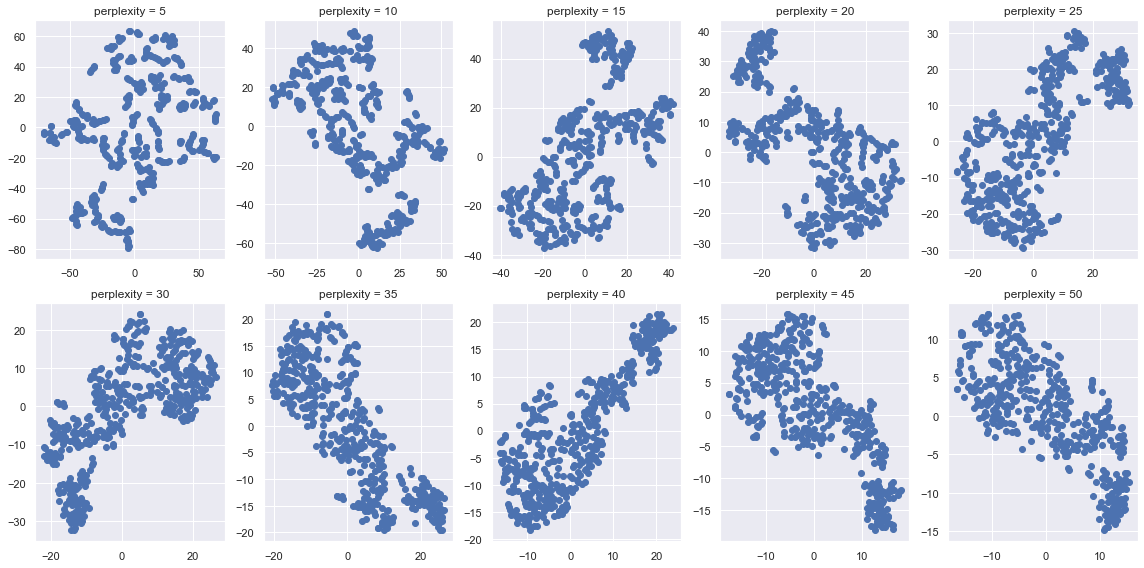

In [48]:
figsize(16, 8)
for i in list(range(1, 11)):
    plt.subplot(2, 5, i)
    perplexity = 5 * i
    tsne = TSNE(perplexity=perplexity, random_state=0)
    X_tsne = tsne.fit_transform(X_transformed)
    plt.scatter(X_tsne[:,0], X_tsne[:, 1])
    plt.title(f'perplexity = {perplexity}')
plt.tight_layout()

In [49]:
tsne = TSNE(perplexity=20, random_state=0)
X_tsne = tsne.fit_transform(X_transformed)

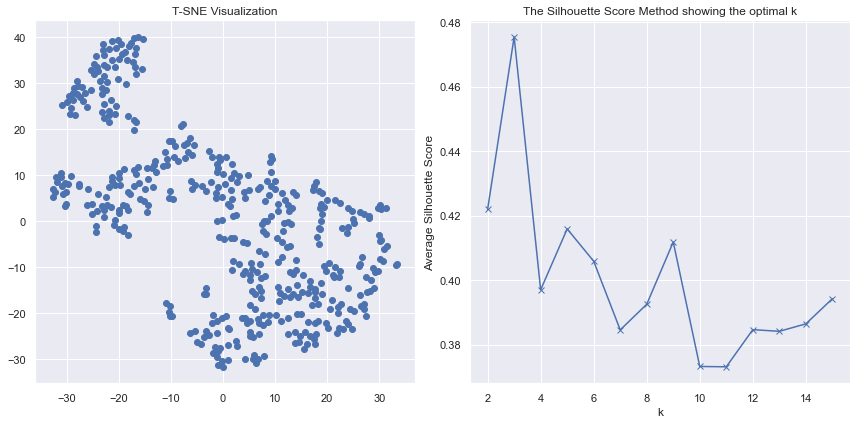

In [50]:
figsize(12, 6)
plt.subplot(1, 2, 1)
plt.scatter(X_tsne[:,0], X_tsne[:, 1])
plt.title('T-SNE Visualization')
plt.subplot(1, 2, 2)
plot_silhouette_score(X_tsne)
plt.tight_layout()

In [51]:
df_tsne = df.copy()
# Choose k = 6
sc_tsne = SpectralClustering(n_clusters=3, affinity='nearest_neighbors', random_state=42)
sc_tsne.fit(X_tsne)
df_tsne['cluster_label_tsne'] = sc_tsne.labels_

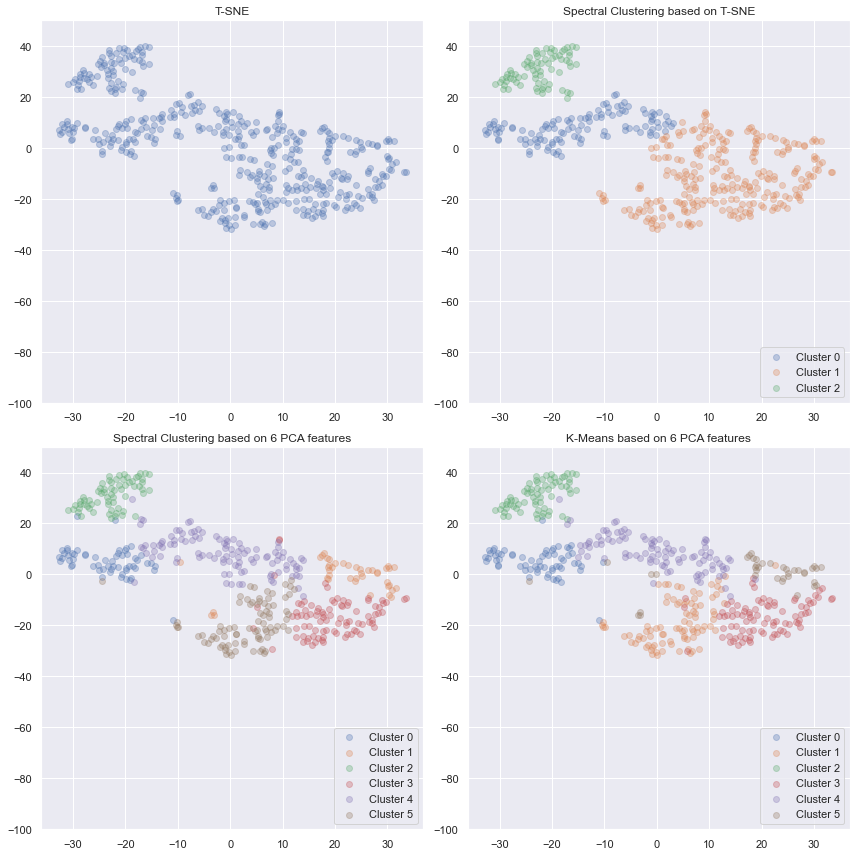

In [52]:
figsize(12, 12)

plt.subplot(2, 2, 1)
plt.scatter(X_tsne[:,0], X_tsne[:, 1], alpha=0.3)
plt.title('T-SNE')
plt.ylim(-100, 50)

plt.subplot(2, 2, 2)
for i in range(3):
    cluster_cond = df_tsne['cluster_label_tsne'] == i
    cluster_index = df_tsne[cluster_cond].index
    plt.scatter(X_tsne[cluster_index, 0], X_tsne[cluster_index, 1], label=f'Cluster {i}', alpha=0.3)
plt.legend(loc='lower right')
plt.title('Spectral Clustering based on T-SNE')
plt.ylim(-100, 50)

n_clusters = 6

plt.subplot(2, 2, 3)
sc = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors',
                        random_state=42)
labels = sc.fit_predict(X_transformed)
for i in range(n_clusters):
    cluster_index = [j for j in range(len(labels)) if labels[j] == i]
    plt.scatter(X_tsne[cluster_index, 0], X_tsne[cluster_index, 1], label=f'Cluster {i}', alpha=0.3)
plt.legend(loc='lower right')
plt.title(f'Spectral Clustering based on {n_clusters} PCA features')
plt.ylim(-100, 50)


plt.subplot(2, 2, 4)
km = KMeans(n_clusters=n_clusters, random_state=42)
labels = km.fit_predict(X_transformed)
for i in range(n_clusters):
    cluster_index = [j for j in range(len(labels)) if labels[j] == i]
    plt.scatter(X_tsne[cluster_index, 0], X_tsne[cluster_index, 1], label=f'Cluster {i}', alpha=0.3)
plt.legend(loc='lower right')
plt.title(f'K-Means based on {n_clusters} PCA features')
plt.ylim(-100, 50)

plt.tight_layout()

(-100.0, 50.0)

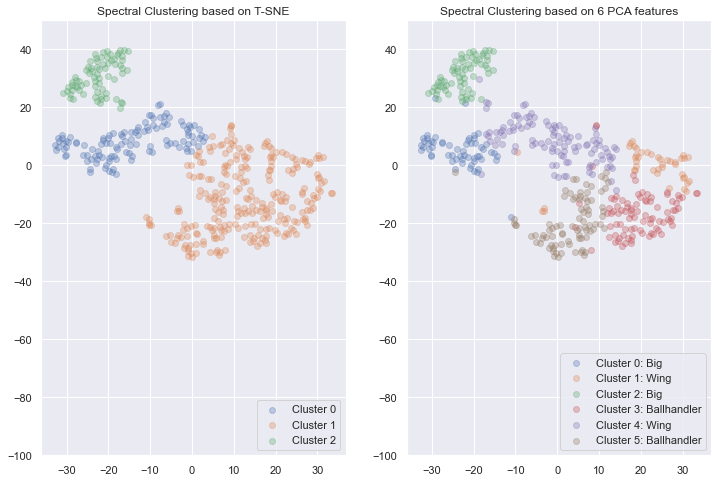

In [53]:
figsize(12, 8)

plt.subplot(1, 2, 1)
for i in range(3):
    cluster_cond = df_tsne['cluster_label_tsne'] == i
    cluster_index = df_tsne[cluster_cond].index
    plt.scatter(X_tsne[cluster_index, 0], X_tsne[cluster_index, 1], label=f'Cluster {i}', alpha=0.3)
plt.legend(loc='lower right')
plt.title('Spectral Clustering based on T-SNE')
plt.ylim(-100, 50)

n_clusters = 6

plt.subplot(1, 2, 2)
sc = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors',
                        random_state=42)
labels = sc.fit_predict(X_transformed)
for i in range(n_clusters):
    cluster_index = [j for j in range(len(labels)) if labels[j] == i]
    plt.scatter(X_tsne[cluster_index, 0], 
                X_tsne[cluster_index, 1], 
                label=f'Cluster {i}: {cluster_dict[i]}', alpha=0.3)
plt.legend(loc='lower right')
plt.title(f'Spectral Clustering based on {n_clusters} PCA features')
plt.ylim(-100, 50)

## Save Models

In [52]:
# df.to_csv('euroleague_cleaned.csv', index=False)

In [53]:
# euroleague_clustering_models = {'pre_pca_pipe': pre_pca_pipe,
#                          'pca': pca,
#                          'pre_cluster_scaler': pre_cluster_scaler,
#                          'cluster_dict': cluster_dict}
# dump_pickle(euroleague_clustering_models, 'euroleague_clustering_models')

In [54]:
# cluster_map_km_to_sc = {0: 3, 
#                         1: 1, 
#                         2: 2, 
#                         3: 5, 
#                         4: 0, 
#                         5: 4, 
#                         6: 6}
# euroleague_clustering_models_km = {'pre_pca_pipe': pre_pca_pipe,
#                             'pca': pca,
#                             'pre_cluster_scaler': pre_cluster_scaler,
#                             'cluster_map_to_spectral_clustering': cluster_map_km_to_sc,
#                             'km': km}
# dump_pickle(euroleague_clustering_models_km, 'euroleague_clustering_models_km')